In [1]:
%pylab inline
gray()

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

# Neural Nets -- Abbreviated

A modern neural network is the composition of several functions that are differentiable where it matters.  

A simple neural net is a chain of functions 
$$ \text{net}(x) = (f_1 \circ f_2 \circ \cdots \circ f_n)(x) $$
although the structure can get more complicated than that. 

Functions are often grouped into _modules_ or _layers_. 
The classic module is of the form
$$ f(a(\mathbf{x})) $$
where $f$ is an activation function and
$$ a(x) = W^T\mathbf{x} $$ 
with _weight_ metrix $W$ and a homogenous input vector $\mathbf{x}$ (think $\phi$ from PRML).
The matrix-multipl $$a(x)$$ is often called a _linear_ module. 

The purpose of $f$ is to add nonlinearity,  
Since compositions of linear functions remain linear, there would be no point without adding a bit of nonlinearity between each matrix multiply.    
The most common activation function is simpy the relu (threshold) function
$$ \text{relu}(\mathbf{a}) = max(a, 0)$$

For large numbers of input (e.g. every pixel of an image)  we use sparse weight matrices, or weight matrices with special strructure. 

A _convolution_ matrix  is a sparse weight matrix where every column is a (flattened) translation of an identical kernel ($k_1 \times k_2$ array of weights), and the number of outputs is roughly proportionate to the number of input pixels.  

For example a $256^2$ input image would require $2^{2\times(8+8)}=2^{32}=4,294,967,296$ weights if the special structure of convolution was not taken into account. In fact there are only 9 unique values. 

Libraries like pytorch do matrix multiplication and differentiation very efficiently, exploiting special hardware if it is available. 

They are particlar fast for convolution matrices. 

# Check your GPU 

Neural networks use GPUs to accelerate computation. 

If the next command does not work, then you _either_ do not have a GPU or you have not installed the nvidia CUDA drivers for you GPU. 

In [2]:
!nvcc --version 
!nvidia-smi

/bin/bash: nvcc: command not found
/bin/bash: nvidia-smi: command not found


Take note of your operating system, whether you have a GPU, which version of python you have, and which version of cuda is installed. 

# Install Torch

Follow the instructions **appropriate for your system**
https://pytorch.org/get-started/locally/ 

Select the appropriate options for your system, bearing in mind whether you have a GPU.


**Restart the notbook** so that the python interpreter can process some of the changes made during installation of torchvision. 

In [3]:
import torch

In [4]:
import torchvision

# An Example

In [5]:
from torchvision.datasets import MNIST

In [6]:
training_data = MNIST('./mndist', train=True,  download=True)

In [7]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mndist
    Split: Train

In [8]:
training_data[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F76DF722A60>, 5)

In [9]:
im, target = training_data[0]

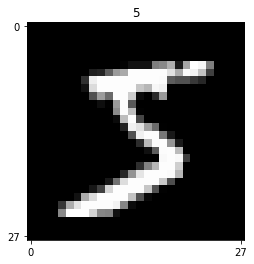

In [10]:
imshow(im);
title(int(target));
xticks([0, im.size[1]-1]);
yticks([0, im.size[0]-1]);

In [11]:
from torchvision import transforms

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [13]:
training_data = MNIST('./mndist', train=True,  download=True, transform=transform)

In [15]:
data, target = training_data[0]
print(type(data), target)

<class 'torch.Tensor'> 5


Text(0, 27, 'Label:5')

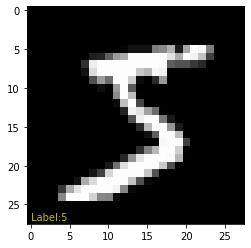

In [20]:
imshow(data.permute(1,2,0))
text(0, 27, f'Label:{target}', c='y')

In [21]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=2)

In [23]:
train_iter = iter(train_loader)
images, targets = train_iter.next()

In [24]:
images.shape

torch.Size([4, 1, 28, 28])

In [25]:
targets.shape

torch.Size([4])

In [28]:
def show_batch(images, targets):
    ncols = int(ceil(sqrt(len(images))))
    nrows = int(ceil(len(images)/ncols))
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if targets is not None:
            xlabel(str(targets[i].numpy()))

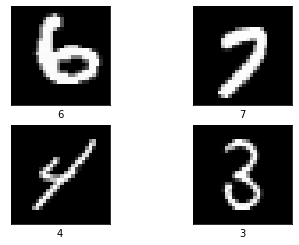

In [29]:
show_batch(images, targets)

In [30]:
import torch.nn as nn
import torch.nn.functional as F

In [31]:
x = images
x.shape

torch.Size([4, 1, 28, 28])

In [32]:
x = x.reshape(x.shape[0], -1)
x.shape

torch.Size([4, 784])

In [33]:
fc = nn.Linear(784, 10)

In [34]:
W, b = fc.parameters()
W.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [35]:
a = fc(x)
a.shape

torch.Size([4, 10])

In [36]:
y = a.argmax(1)
y.shape

torch.Size([4])

In [39]:
def show_batch(images, targets, predictions=None):
    ncols = int(ceil(sqrt(len(images))))
    nrows = int(ceil(len(images)/ncols))
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()))
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))


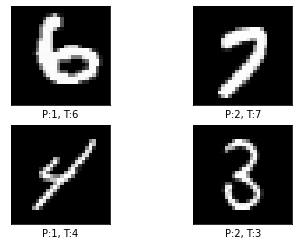

In [40]:
show_batch(images, targets, y)

In [41]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.flatten(1)
        a = self.fc(x)
        return a   

In [42]:
import torch.optim as optim

net = MyNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Will discuss lr and momentum later

While the next cell is running, open up a terminal and type `nvidia-smi` to make sure you are using 100% of your GPU. This is not so important on such a small dataset / model, but for larger problems the (linear) time sivings add up. 

In [46]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'epoch:{epoch+1}, iter:{i+1:5},  loss: {running_loss / 2000}' )
            running_loss = 0.0

print('Finished Training')


epoch:1, iter: 2000,  loss: 0.29893253383703994
epoch:1, iter: 4000,  loss: 0.29750677406031173
epoch:1, iter: 6000,  loss: 0.3048578102205356
epoch:1, iter: 8000,  loss: 0.3002424069198314
epoch:1, iter:10000,  loss: 0.29854868764200365
epoch:1, iter:12000,  loss: 0.2917037874784437
epoch:1, iter:14000,  loss: 0.2891615700723487
epoch:2, iter: 2000,  loss: 0.29370043264955165
epoch:2, iter: 4000,  loss: 0.2967570430762134
epoch:2, iter: 6000,  loss: 0.27159812959117696
epoch:2, iter: 8000,  loss: 0.2876577325833496
epoch:2, iter:10000,  loss: 0.2909529140178347
epoch:2, iter:12000,  loss: 0.28442830032209165
epoch:2, iter:14000,  loss: 0.3009890241249232
Finished Training


In [ ]:
y = net(images).argmax(1)

In [ ]:
show_batch(images, targets, y)

**ALERT: This was ALL on TRAINING data -- we NEED TEST!!!***

In [ ]:
test_data = MNIST('./mndist', train=False,  download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=2)

In [ ]:
with torch.no_grad():
    cm = np.zeros((10,10), dtype=np.int64)
    for x, y in iter(test_loader):
        p = net(x).argmax(1).numpy()
        for pred, true in zip(p, y):
            cm[int(pred), int(true)] += 1

In [ ]:
import pandas as pd
df_cm = pd.DataFrame(cm, index = arange(10), columns = arange(10))
df_cm

Install $\texttt{seaborn}$ to plot confusion matrices (and many other things) easily.   

In [ ]:
import seaborn as sn

In [ ]:
figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='d', annot=True);
ylabel('pred')
xlabel('true');

In [ ]:
acc = np.trace(cm)/ np.sum(cm)
acc

In [ ]:
def report_from_cm(cm, labels, beta=1):
    df = pd.DataFrame(index=list(labels)+['avg/total'], columns=['precision', 'recall', 'fmeasure','support'])
    for i, label in enumerate(labels):
        tp = cm[i,i]
        p = cm[i,:].sum()
        support = cm[:,i].sum()
        fp = p-tp
        fn = support-tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fmeasure = (1+beta**2)*precision*recall/((beta**2)*precision + recall)
        df['precision'][label] = precision
        df['recall'][label] = recall
        df['fmeasure'][label] = fmeasure
        df['support'][label] = support
    df['precision']['avg/total'] = df['precision'][:'avg/total'].mean()
    df['recall']['avg/total'] = df['recall'][:'avg/total'].mean()
    df['fmeasure']['avg/total'] = df['fmeasure'][:'avg/total'].mean()
    df['support']['avg/total'] = df['support'][:'avg/total'].sum()
    return df

In [ ]:
report_from_cm(cm, range(10))

# Lab Activity


Modify the training code as follows:
1. (Optional) Add a `torchvision.transforms.Resize` to the transforms to reduce the size of each image (e.g. to 8x8) so that training is fast on your computer.   
1. Keep track of the loss after each checkpoint so that you can plot it when training completes. 
2. At each checkpoint, compute the loss on the evaluation data and save it to a different list so that you can plot bothe the training _and_ the test loss when training completes. 
3. If necessary, increase the number of epochs until you can see that you overfit the data. 
4. Submit **only** a printout of the plot of training vs test loss, and the code for the training loop. 